## Langevin Dynamics for Spectroscopy ##

Last time, we examined the effects of a Langevin thermostat on a collection of charged particles diffusing throgh an open box. In spectroscopy, of course, we aren't really interested in diffusion per se. Our interest is in the much faster time scales (fs to ns) of electronic and vibrational motion. Even in this context, however, Langevin dynamics allow us to capture several physical effects important in spectroscopy. 

First, Langevin dynamics allow us to control the average kinetic energy -- i.e., temperature -- of the particles in our simulation. This allows us to speak meaningfully of a simulation box being "equilibrated" and, in principle, can be used to study (on a small scale) processes like phase transitions from solid to liquid or the temperature-induced folding or unfolding of a protein. (You should have seen behavior related to this in the simulations you just ran. ) In as much as having the right initial starting state is critical to getting the right spectroscopic signal, Langevin dynamics are thus quite important in spectroscopic simulations. 

Second, and of special relevance to spectroscopy, Langevin dynamics allows us to study the effects of *dissipation* and *dephasing* in optical and infrared spectroscopy. *Dissipation* is the process by which an initially excited system loses energy to its environment. Dephasing (or decoherence) is the process by which intially coherent motion -- i.e. oscillations with a well-defined phase relative to the initial state -- becomes randomized. Although they may seem like abstract concepts, dephasing and dissipation both play critical roles in the determination of optical and infrared lineshapes and in energy-transfer processes. 

In this exercise, we'll get our first taste of the way MD simulations can be used to evaluate spectroscopic signals, particularly in the presence of dissipation. As a simple molecular model, we'll consider a collection of diatomic molecules with parameters roughly matching those of a C=O bond. The main changes required to implement this model in our code are (1) to update the particle-placement code so that positive and negative particles are always distributed pair-wise (each pair representing a single molecule) and (2) to add to the ``calc_accel()`` routine a contribution from the bonding force between the two atoms in the molecule. In our simple model, the bonding force within each molecule is described by a harmonic potential
\begin{align}
V({\bf r}^{(m)}, {\bf r}^{(n)}) = \frac{K}{2} \left( \left \| {\bf r}^{(m)} - {\bf r}^{(n)} \right \| - R_{\text{bond}} \right)^2,
\end{align}
where $K$ is a force constant, related to the oscillation frequency of the bond by $\omega = \sqrt{\frac{K}{M}}$. 

Play with the simulation parameters provided below, and answer the questions using your observations from the simulations. 

In [225]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
import time
import ipywidgets as widgets

import numpy as np

from IPython.display import Javascript, display
from ipywidgets import widgets
import IPython.display as ipd



def run_all(ev):
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

gamma_slider = widgets.FloatSlider(
    value=50,
    min=0,
    max=100,
    step=1.0,
    description='$\gamma$ (pg/s):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)
    
temp_slider = widgets.FloatSlider(
    value=300,
    min=0,
    max=1000,
    step=1.0,
    description='T (K):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)

emax_slider = widgets.FloatSlider(
    value=100,
    min=0,
    max=250,
    step=1.0,
    description='$E_{max}\cdot 10^{-4}$ (statV/cm):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)

tmax_slider = widgets.FloatSlider(
    value=3,
    min=0,
    max=10,
    step=1.0,
    description='$t_{max}$ (ps)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0f',
)

tpulse_slider = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=10,
    step=0.5,
    description='$t_{pulse}$ (ps)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

taupulse_slider = widgets.FloatSlider(
    value=20,
    min=10,
    max=1000,
    step=0.5,
    description='$\\tau_{pulse}$ (fs)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

vpulse_slider = widgets.FloatSlider(
    value=4.0,
    min=0,
    max=100,
    step=0.1,
    description='$\\nu_{pulse}$ (THz)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)



nmol_slider = widgets.IntSlider(
    value=15,
    min=1,
    max=50,
    step=1,
    description='N$_{mol}$',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

skip_box = widgets.Checkbox(
    value = True,
    description = 'Skip frames?'
)

button = widgets.Button(description="Go!")
button.on_click(run_all)

pulse_box = widgets.VBox([tpulse_slider, taupulse_slider, vpulse_slider, emax_slider])
part_box = widgets.VBox([nmol_slider, tmax_slider, gamma_slider, temp_slider])
# # display(phase_slider)
# # display(freq_slider)
# # display(tau_slider)
# display(nmol_slider)
# display(tmax_slider)
# display(tpulse_slider)
# display(taupulse_slider)
# display(vpulse_slider)
# display(gamma_slider)
# display(temp_slider)
# display(emax_slider)
display(widgets.HBox([pulse_box, part_box]))
display(skip_box)
display(button)

<IPython.core.display.Javascript object>

Checkbox(value=True, description='Skip frames?')

Button(description='Go!', style=ButtonStyle())

In [ ]:
gamma = gamma_slider.value*1e-12  # grams/second
Temp = temp_slider.value          # K
Emax = emax_slider.value*1e+4   # Maximum electric field in statV/cm
tmax = tmax_slider.value*1e-12      # Total simulation time in seconds
tpulse = tpulse_slider.value*1e-12      # Pulse arrival time in seconds
tau_pulse = taupulse_slider.value*1e-15  # Pulse width (std. dev.) in seconds
Nmol = nmol_slider.value
dt=1e-15     # Time-step in seconds
tmax = tmax_slider.value*1e-12


vpulse = vpulse_slider.value*1e+12                      # pulse frequency in Hz
skip_frames = skip_box.value

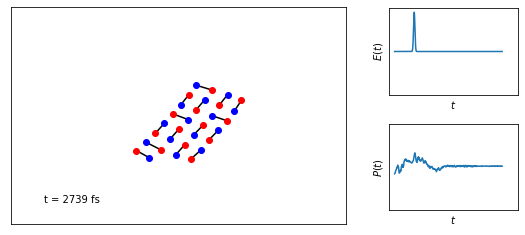

In [ ]:
def calc_accel(x,y,efield):
    Minv = 1/M
    
    ax = 4*epso*(Ro**4)*Minv/(x**5) - 4*epso*Minv*(Ro**4)/((L-x)**5)
    ay = 4*epso*(Ro**4)*Minv/(y**5) - 4*epso*Minv*(Ro**4)/((L-y)**5)

    # X differences: Rx[m,n] is the x-displacement between particles m and n
    Rx = x - x.transpose()
    
    # Y differences: Ry[m,n] is the y-displacement between particles m and n
    Ry = y - y.transpose()
    
    # Distance matrix: R[m,n] is distance between particles m and n
    R = np.sqrt(np.power(Rx,2) + np.power(Ry,2))
    
    # Fill the diagonal elements with 1 to avoid divide_by_zero error
    np.fill_diagonal(R,1)
    
    Rinv = (1.0)/R
    np.fill_diagonal(Rinv,0)
    Rinv3 = Rinv*Rinv*Rinv
    Rinv4 = Rinv3*Rinv
    Rinv8 = Rinv3*Rinv3*Rinv*Rinv
    Rinv14 = Rinv8*Rinv3*Rinv3
    Ro6 = Ro**6
    
    ax += np.reshape(np.sum(QQ*Rx*Minv*Rinv3,1), (Npart,1))
    ay += np.reshape(np.sum(QQ*Ry*Minv*Rinv3,1), (Npart,1))
    
    mask = np.abs(QQ)/Qo
    
    ax += 12.0*epso*Minv*Ro6*np.reshape(np.sum(mask*(Ro6*Rx*Rinv14 - Rx*Rinv8), 1), (Npart,1))
    ay += 12.0*epso*Minv*Ro6*np.reshape(np.sum(mask*(Ro6*Ry*Rinv14 - Ry*Rinv8), 1), (Npart,1))
    
    dX = np.diag(Rx[0:Npos,Npos:])
    dY = np.diag(Ry[0:Npos,Npos:])
    dR = np.sqrt(np.power(dX,2) + np.power(dY,2))
    
    ax[0:Npos,:] -= np.reshape(K*Minv*(dR-Rbond)*(dX/dR), (Npos,1))
    ay[0:Npos,:] -= np.reshape(K*Minv*(dR-Rbond)*(dY/dR), (Npos,1))
    
    ax[Npos:,:] += np.reshape(K*Minv*(dR-Rbond)*(dX/dR), (Npos,1))
    ay[Npos:,:] += np.reshape(K*Minv*(dR-Rbond)*(dY/dR), (Npos,1))
    
    ay += np.reshape(Q*efield*Minv, (Npart,1))
    return ax,ay
    
#############################
######## Main Changes #######
#############################

def vv_step(x,y,vx,vy,ax,ay,efield):
    axrand = math.sqrt(2.0*kB*Temp*gamma/dt)*np.random.normal(0,1,(Npart,1))/M
    ayrand = math.sqrt(2.0*kB*Temp*gamma/dt)*np.random.normal(0,1,(Npart,1))/M
    xnew = np.mod(x + B*dt*vx + 0.5*B*dt*dt*(ax + axrand), L)
    ynew = np.mod(y + B*dt*vy + 0.5*B*dt*dt*(ay + ayrand), L)
    axnew,aynew = calc_accel(xnew,ynew,efield)
    vxnew = A*vx + 0.5*dt*(A*ax + axnew + 2.0*B*axrand)
    vynew = A*vy + 0.5*dt*(A*ay + aynew + 2.0*B*ayrand)
    return xnew,ynew,vxnew,vynew,axnew,aynew

##############################
##############################

def init_plot():
    
    fig = plt.figure(1)
    ax1 = plt.clf()
    
    bondLines = []
    for m in range(0, Nmol):
        bondLine, = plt.plot([X[m],X[Npos+m]], [Y[m],Y[Npos+m]],'k-')
        bondLines.append(bondLine)
        
    txt = plt.text(0.1*L,0.1*L,'t = '+str(round(0))+' fs')
    negLine, = plt.plot(X[0:Npos],Y[0:Npos],'bo')
    posLine, = plt.plot(X[Npos:],Y[Npos:],'ro')
    
    
    plt.xlim([0,L])
    plt.ylim([0,L])
    plt.xticks([])
    plt.yticks([])
    
    ax2 = plt.axes([1.0,0.575,0.3,0.3])
    plt.xlabel('$t$')
    plt.ylabel('$E(t)$')
    field_line, = plt.plot(taxis,Efield)
    plt.xticks([])
    plt.yticks([])
    plt.ylim([-1.1,1.1])
#     plt.ylim([0,dt*Nsteps])
    
    ax3 = plt.axes([1.0,0.175,0.3,0.3])
    plt.xlabel('$t$')
    plt.ylabel('$P(t)$')
    pol_line, = plt.plot(taxis,Pol)
    plt.xticks([])
    plt.yticks([])
    plt.ylim([-1,1])
#     plt.ylim([0,dt*Nsteps])
    
    return fig,ax1,ax2,ax3,negLine,posLine,txt,field_line,pol_line,bondLines

def update_plot(n):
    negPts.set_ydata(Y[0:Npos])
    negPts.set_xdata(X[0:Npos])
    posPts.set_ydata(Y[Npos:])
    posPts.set_xdata(X[Npos:])
    txt.set_text('t = '+str(round(n*dt*1e+15))+' fs')
    
    for m in range(0, Nmol):
        bondLines[m].set_xdata([X[m],X[Npos+m]])
        bondLines[m].set_ydata([Y[m],Y[Npos+m]])
    
    plt.sca(ax2)
    #plt.plot(taxis[0:n]/Emax, 'k.')
    field_line.set_xdata(taxis[0:n])
    field_line.set_ydata(Efield[0:n]/Emax)
#     plt.ylim([-1,1])
    #plt.xlim([0,dt*Nsteps])
    
    plt.sca(ax3)
    #plt.plot(taxis[0:n]/Emax, 'k.')
    pol_line.set_xdata(taxis[0:n])
    pol_line.set_ydata(Pol[0:n])
#     plt.ylim([-1,1])
    #plt.xlim([0,dt*Nsteps])
    
    fig.canvas.draw()
    display(plt.gcf())
    ipd.clear_output(wait=True)
    
def gauss_pulse(t):
    return Emax*np.cos(2.0*math.pi*(t-to)*nu)*np.exp(-((t-to)**2)/(2.0*sigma*sigma))

epso = 190.0*(1.38064852e-23)*(1e+3)*(1e+4)
Ro = 10.0e-8

L = 0.25e-6
to = tpulse
sigma = tau_pulse
nu = vpulse


Nsteps=int(round(tmax/dt))
M=12*(1.66054e-24)   # Mass in g
Qo = 4.803e-10         # Elementary charge in statCoulombs
taxis = np.arange(0,tmax,dt)   # Time axis (array of time steps)

#####################################################
######### Constants for Langevin integrator #########
#####################################################

kB = 1.38064852e-16                  # erg/K
B = 1.0/(1.0 + 0.5*gamma*dt/M)
A = B*(1.0 - 0.5*gamma*dt/M)

#####################################################
#####################################################

# Set Particle charges
Npart = 2*Nmol

# One positive particle per molecule
Npos = Nmol
Q = np.zeros((Npart))  # Empty vector for particle charges
Q[0:Npos] = +Qo    # First Npos particles are positive
Q[Npos:] = -Qo     # Last Nneg particles are negative

# QQ is an (Npart)x(Npart) matrix where QQ[m,n] is the 
# *product* of the charges on particles m and n
QQ = np.reshape(Q, (Npart,1))@np.reshape(Q, (1,Npart))

# Set QQ elements that correspond to intermolecular bonds to zero
np.fill_diagonal(QQ[0:Npos,Npos:].view(), 0)
np.fill_diagonal(QQ[Npos:,0:Npos].view(), 0)


# Set initial velocities to zero 
VX = np.zeros((Npart,1))
VY = np.zeros((Npart,1))

# Generate the pulse profile
Efield = gauss_pulse(taxis)

Rbond = 1.24e-8
wo = 6.28*35e12        # Oscillator (angular) frequency
K = M*wo**2

AX = 1e+50
AY = 1e+50
while max(np.max(np.abs(AX)), np.max(np.abs(AY)))>1.0e+21:

    # Generate a vector of random *molecular* positions
    Rx = np.random.random((Nmol))*L
    Ry = np.random.random((Nmol))*L

    # Generate random orientations between 0 and 2*pi radians
    Theta = np.random.random((Nmol))*2.0*math.pi

    # Generate positions for positive and negative atoms in each molecule
    # Note: X[n] and X[n+Npos] are bonded pairs! (Same with Y[n] and Y[n+Npos].)
    X = np.concatenate((Rx+0.5*Rbond*np.cos(Theta),Rx-0.5*Rbond*np.cos(Theta)))
    Y = np.concatenate((Ry+0.5*Rbond*np.sin(Theta),Ry-0.5*Rbond*np.sin(Theta)))
    X.shape = (Npart,1)
    Y.shape = (Npart,1)

    # Calculate accelerations at initial positions
    AX,AY = calc_accel(X,Y,Efield[0])

if skip_frames:
    UpdateFreq = 249
else:
    UpdateFreq = 10
    
Pol = np.zeros(np.shape(Efield))
fig,ax1,ax2,ax3,negPts,posPts,txt,field_line,pol_line,bondLines = init_plot()
for n in range(0,Nsteps):
    X,Y,VX,VY,AX,AY = vv_step(X,Y,VX,VY,AX,AY,Efield[n])
    Pol[n] = 10*np.mean(Q*np.reshape(Y-0.5*L,(Npart,)))/(4*Qo*Rbond)
    if(n%UpdateFreq==0):
        update_plot(n)


# Exercise

1. Run a simulation with $\tau_{pulse} = 1000 fs$, $\nu_{pulse} = 0$ THz, $E_{max} = 250$ statV/cm, and with $t_{pulse}$ and $t_{max}$ set to 3 ps. Leave the other parameters at their default values. This will produce an electric field that increases gradually during the simulation. What happens to the molecules as the simulation progresses? Why? 


2. Now run a simulation with a single particle, $\tau_{pulse} = 200$ fs, $\nu_{pulse} = 4$ THz, $E_{max} = 100$ statV/cm, $t_{pulse} = 1.5 ps$ and $t_{max} = 3$ ps. Keep the "Skip Frames" box turned off so that you can watch the particle trajectory in detail. What kind of motion does the pulse induce in the oscillator? What kind of spectroscopy does this represent? Can you find a pulse frequency that maximizes the response? 

3. Finally, repeat the last simulation with $\nu_{pulse} = 50$ THz. What kind of motion does this induce in the oscillator? What sort of spectroscopy does it represent? 

4. Finally, repeat the last simulation with a larger number (say 15) of particles. (You can leave the "Skip Steps" box unchecked to speed up the simulation). 

In [ ]:
from hublib import ui 
ui.HideCodeButton()


In [ ]:
print(nmol_slider.value)